# Imports

In [71]:
from data_classes import LAQNData, HealthData
from os import path
import pandas as pd

# Load data

### Load the hourly NO$_2$ data

In [72]:
data_folder = path.join(path.abspath(""), "LAQN_data")
species = "NO2"
url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
start_date = "2000-01-01"
end_date = "2021-01-01"

In [73]:
NO2_hourly = LAQNData(url, data_folder, species, start_date, end_date)

In [74]:
hourly_df = NO2_hourly.read_csv(index_col="date")
print(hourly_df.shape)

Reading NO2_hourly_2000-01-01_2021-01-01.csv...
(184105, 192)


In [86]:
hourly_df.tail()

,TD0,BG3,BG1,BG2,BN2,BN3,BN1,BX5,BX2,BQ7,...,WMD,WM0,MY1,WM6,WMZ,WMB,NB1,WM8,WM9,VS1
date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 20:00:00,NaN,NaN,NaN,27.7,NaN,NaN,NaN,NaN,26.6,21.9,...,NaN,26.8,25.8,30.9,NaN,28.6,43.2,NaN,NaN,NaN
2020-12-31 21:00:00,NaN,NaN,NaN,29.4,NaN,NaN,NaN,NaN,25.6,20.7,...,NaN,25.1,27.8,30.1,NaN,28.1,31.0,NaN,NaN,NaN
2020-12-31 22:00:00,NaN,NaN,NaN,21.5,NaN,NaN,NaN,NaN,18.6,15.6,...,NaN,25.1,24.3,34.2,NaN,32.5,37.0,NaN,NaN,NaN
2020-12-31 23:00:00,NaN,NaN,NaN,21.7,NaN,NaN,NaN,NaN,16.6,13.5,...,NaN,26.0,21.5,33.1,NaN,29.4,41.4,NaN,NaN,NaN
2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Load the weekly mortality per capita data

In [81]:
data_folder = path.join(path.abspath(""), "mortality_data")
filename = "weekly_mortality_London.csv"

In [82]:
mortality_weekly = HealthData(data_folder, filename=filename)

In [83]:
mortality_df = pd.DataFrame(mortality_weekly.read_csv(index_col="date"))
print(mortality_df.shape)

Reading weekly_mortality_London.csv...
(581, 1)


In [85]:
mortality_df.tail()

,weekly_deaths
date,
2021-01-22,2417
2021-01-29,2302
2021-02-05,1922
2021-02-12,1545
2021-02-19,1367


# Process data

### Resample the hourly NO$_2$ data using a custom date list

In [79]:
weekly_dates = mortality_df.index

In [80]:
weekly_NO2_df = hourly_df.groupby(weekly_dates[weekly_dates.searchsorted(hourly_df.index)]).mean()

IndexError: index 495 is out of bounds for axis 0 with size 495

We've now generated a dataframe of weekly mean NO$_2$ concentrations (from the hourly data) using the weekly dates given by the mortality dataset. 
- The `searchsorted()` function takes the `hourly_df` index and inserts it into `weekly_dates` to return an array of indices where the hourly elements should be inserted to maintain order in the weekly dates. See docs [here](https://pandas.pydata.org/pandas-docs/version/0.21.1/generated/pandas.DatetimeIndex.searchsorted.html).
- Placing these indices inside `weekly_dates[]` produces an array the same length as the hourly index, where each entry is the corresponding "weekly" date.
- The `groupby()` operation then performs the `mean()` function on the hourly data, grouping by the assigned weekly dates in the previous step. See docs [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html).

### Spatially average the NO$_2$ data for all of London

In [42]:
NO2_df = pd.DataFrame(weekly_NO2_df.mean(axis=1), columns=["mean_NO2"]).join(mortality_df)

In [43]:
NO2_df

,mean_NO2,weekly_deaths
date,,
2010-01-08,54.274204,1226
2010-01-15,59.165384,1262
2010-01-22,67.432424,1186
2010-01-29,64.820489,1093
2010-02-05,67.035762,1035
...,...,...
2020-12-04,45.852628,1029
2020-12-11,41.407170,1065
2020-12-18,35.492285,1167


<AxesSubplot:xlabel='mean_NO2', ylabel='weekly_deaths'>

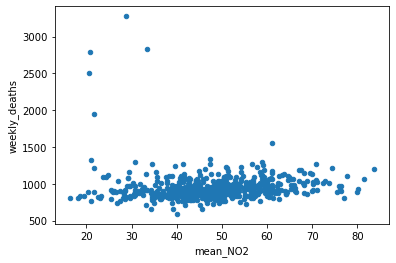

In [45]:
NO2_df.plot.scatter(x="mean_NO2", y="weekly_deaths")